<a href="https://colab.research.google.com/github/maneveli/Canny-Edge-Detector/blob/master/LM_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install femedu

import math
import sys
import numpy as np
import matplotlib.pyplot as plt

from femedu.examples import Example

from femedu.domain import System, Node
from femedu.solver import NewtonRaphsonSolver

from femedu.elements.finite import Quad
from femedu.materials import PlaneStress
from femedu.mesher import *


**Reference Solution: Beam Theory**


In [52]:
#units in Pa, Nm, m

M = 50e3
E = 70e9
v = .35
h = 1
b = .35
L = 8

I = (b * h**3) / 12
displacement = (M * L**2) / (2 * E * I)
rotation = (M * L) / (E * I)

print("Displacement (m):", displacement)
print("Rotation:(rad)", rotation)

Displacement (m): 0.0007836734693877551
Rotation:(rad) 0.0001959183673469388


In [53]:
yA = -(h/2)
yB = (h/2)
vA = displacement + (yA*rotation)
vB = displacement + (yB*rotation)

print("In-plane displacement at node A: (m)", vA)
print("In-plane displacement at node B (m):", vB)



In-plane displacement at node A: (m) 0.0006857142857142858
In-plane displacement at node B (m): 0.0008816326530612245


In [54]:
y = np.linspace(-h/2, h/2, 1000)
stress = (M * y) / I

# Example values
print("Stress at y = -50cm:", stress[0], "Pa")
print("Stress at y = 0:", stress[500], "Pa")
print("Stress at y = 50cm:",stress[-1], "Pa")

Stress at y = -50cm: -857142.8571428573 Pa
Stress at y = 0: 858.0008580009339 Pa
Stress at y = 50cm: 857142.8571428573 Pa


**Convergence Study I**

mesh with 4 elements along x
mesh with 2 elements along y
+
[ 8.57103096e-06 -6.85714940e-05]


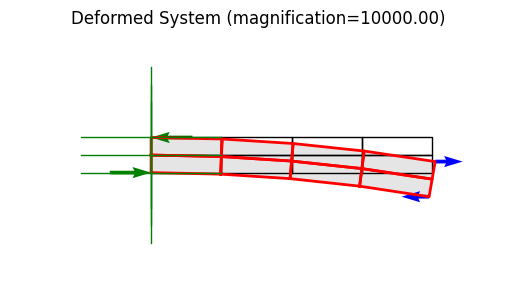

mesh with 8 elements along x
mesh with 4 elements along y
+
[ 2.13477489e-05 -1.71359893e-04]


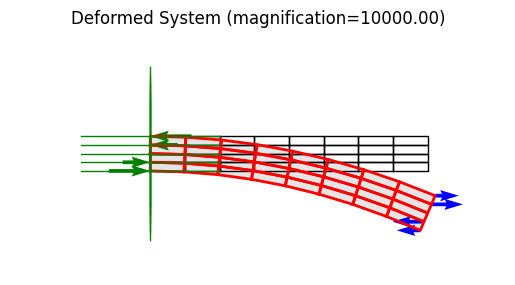

mesh with 16 elements along x
mesh with 8 elements along y
+
[ 2.99094945e-05 -2.39941759e-04]


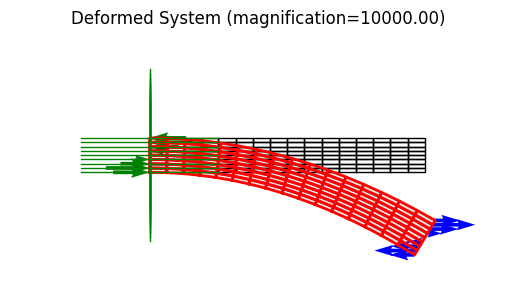

In [55]:
class BeamAnalysis:

    def set_boundary_conditions(nodes, L):
        for node in nodes:
            xNd = node.getPos()
            if np.isclose(xNd[0], 0):
                node.fixDOF(['ux', 'uy'])
        return None

    def apply_loads(nodes, L, h, M):
        end_nodes = [node for node in nodes if np.isclose(node.getPos()[0], L)]

        for node in end_nodes:
            for elem in node.elements:
                for face in elem.faces:
                    for x, area in zip(face.pos, face.area):
                        Xo = np.array([L, 0.0])
                        No = np.array([1.0, 0.0])
                        if np.abs((x - Xo) @ No) < 1.0e-2 and No @ area / np.linalg.norm(area):
                            y = (x - Xo)[1]
                            V = M / (h ** 3 / 12) * y
                            face.setLoad(V, 0.0)


    def solve(L, h, E, v, b, M, Nx=[4, 8, 16], Ny=[2, 4, 8]):

        convDisp = []
        convN = []

        for Nx, Ny in zip(Nx, Ny):
            print(f"mesh with {Nx} elements along x")
            print(f"mesh with {Ny} elements along y")

            model = System()
            model.setSolver(NewtonRaphsonSolver())

            mesher = PatchMesher(model, (0., -h / 2), (L, -h / 2), (L, h / 2), (0., h / 2))
            nodes, elements = mesher.quadMesh(Nx, Ny, Quad, PlaneStress({'E': E, 'v': v, 'b': b}))

            BeamAnalysis.set_boundary_conditions(nodes, L)
            BeamAnalysis.apply_loads(nodes, L, h, M)
            model.solve()

            print(nodes[-1].getDisp())
            convN.append(Nx)
            convDisp.append(nodes[-1].getDisp(['uy']))

            # Post-processing: Plot stress distributions and perform convergence study
            model.plot(factor=10000.0, filename=f"beam_deformed_Nx{Nx}.png", show_bc=True, show_loads=True)
if __name__ == "__main__":
    BeamAnalysis.solve(L, h, E, v, b, M)



**Convergence Study II**

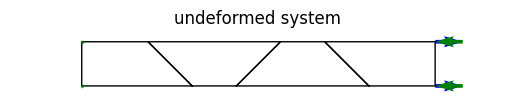

+
+

System Analysis Report

Nodes:
---------------------
  Node_1503:
      x:    [0. 0.]
      fix:  ['ux', 'uy']
      u:    [0. 0.]
  Node_1504:
      x:    [250.   0.]
      u:    [0.49570374 0.03881259]
  Node_1505:
      x:    [350.   0.]
      u:    [0.70692182 0.04741543]
  Node_1506:
      x:    [650.   0.]
      u:    [1.3188311  0.09810863]
  Node_1507:
      x:    [800.   0.]
      u:    [1.62495897 0.12336921]
  Node_1508:
      x:    [  0. 100.]
      fix:  ['ux', 'uy']
      u:    [0. 0.]
  Node_1509:
      x:    [150. 100.]
      u:    [ 0.29376605 -0.0520084 ]
  Node_1510:
      x:    [450. 100.]
      u:    [ 0.89364299 -0.00723648]
  Node_1511:
      x:    [550. 100.]
      u:    [1.09791828 0.00983241]
  Node_1512:
      x:    [800. 100.]
      u:    [1.60811315 0.05194348]

Elements:
---------------------
  Quad_1018: nodes ( Node_1503 Node_1504 Node_1509 Node_1508 )
      material: list
      strain (0): xx=1.979e-03 yy=-1.738e-04 xy=7.729e-05 zz=-6.320e-04
     

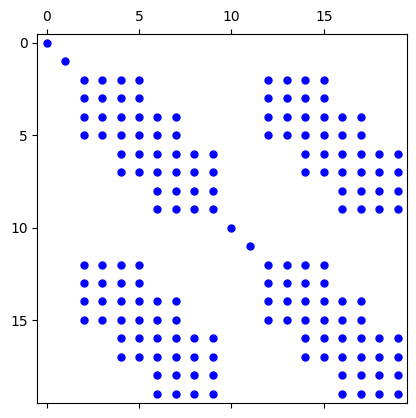

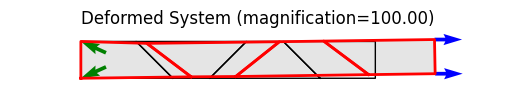

In [56]:
#IRREGULAR MESH


import numpy as np

from femedu.examples import Example

from femedu.domain import System, Node
from femedu.solver import NewtonRaphsonSolver
from femedu.elements.linear import Quad
from femedu.materials import PlaneStress


class ExamplePlate03(Example):

    def problem(self):
        # ========== setting mesh parameters ==============

        N = 4         # number of elements in the mesh
        Lx = 800.0    # length of plate in the x-direction
        Ly =  100.0    # length of plate in the y-direction

        # ========== setting material parameters ==============

        params = dict(
            E  = 70000.,    # Young's modulus
            nu = 0.350,     # Poisson's ratio
            t  = .35       # thickness of the plate
        )

        # ========== setting load parameters ==============

        px  = .5        # uniform load normal to x=const
        py  =  .5       # uniform load normal to y=const
        pxy =  0   # uniform shear load on x=const and y=const

        # ========== setting analysis parameters ==============

        target_load_level = 1.00     # reference load
        max_steps = 2                # number of load steps: 2 -> [0.0, 1.0]

        # define a list of target load levels
        load_levels = np.linspace(0, target_load_level, max_steps)

        #
        # ==== Build the system model ====
        #

        model = System()
        model.setSolver(NewtonRaphsonSolver())

        # create nodes

        nodes = (
            Node(0.0*Lx, 0.0*Ly),  # nd 0
            Node(0.3125*Lx, 0.0*Ly),  # nd 1
            Node(0.4375*Lx, 0.0*Ly),  # nd 2
            Node(0.8125*Lx, 0.0*Ly),  # nd 3
            Node(1.0*Lx, 0.0*Ly),  # nd 4
            #
            Node(0.0*Lx, 1*Ly),  # nd 5
            Node(0.1875*Lx,1*Ly),  # nd 6
            Node(0.5625*Lx, 1*Ly),  # nd 7
            Node(0.6875*Lx, 1*Ly),  # nd 8
            Node(1.0*Lx, 1*Ly),  # nd 9
            #

        )

        elements = (
            Quad(nodes[0],nodes[1],nodes[6],nodes[5],PlaneStress(params)),  # elem 0
            Quad(nodes[1],nodes[2],nodes[7],nodes[6],PlaneStress(params)),  # elem 1
            Quad(nodes[2],nodes[3],nodes[8],nodes[7],PlaneStress(params)),  # elem 2
            Quad(nodes[3],nodes[4],nodes[9],nodes[8],PlaneStress(params)),  # elem 3
            #

        )

        model.addNode(*nodes)
        model.addElement(*elements)

        # define support(s)

        fix_x = (0,5)
        fix_y = (0,5)

        for idx in fix_x:
            nodes[idx].fixDOF('ux')    # horizontal support
        for idx in fix_y:
            nodes[idx].fixDOF('uy')    # vertical support

        # ==== complete the reference load ====

        # Surface loads on the right side
        elements[3].setSurfaceLoad(1, px)
        elements[3].setSurfaceLoad(1, py)


        # these are only nodal forces as part of the reference load
        # .. load only the upper node

        model.plot(factor=0., title="undeformed system", filename="plate09_undeformed.png", show_bc=1)

        model.setLoadFactor(0.0)
        model.solve()

        # for k in range(25):
        #     name = f"plate08_mode{k:2d}.png"
        #     model.plotBucklingMode(mode=k,filename=name,factor=25)

        model.setLoadFactor(100.0)
        model.solve()

        model.solver.showKt(filename="plate09_spy_Kt.png")

        model.report()

        model.plot(factor=100., filename="plate09_deformed.png")


if __name__ == "__main__":
    ex = ExamplePlate03()
    ex.run()

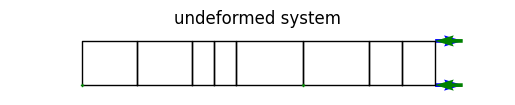

+
+

System Analysis Report

Nodes:
---------------------
  Node_1513:
      x:    [0. 0.]
      fix:  ['ux', 'uy']
      u:    [0. 0.]
  Node_1514:
      x:    [125.   0.]
      u:    [-0.02031437  0.91998282]
  Node_1515:
      x:    [250.   0.]
      u:    [0.21983925 0.43549388]
  Node_1516:
      x:    [300.   0.]
      u:    [0.17779101 0.60225541]
  Node_1517:
      x:    [350.   0.]
      u:    [0.13271775 0.55910085]
  Node_1518:
      x:    [500.   0.]
      fix:  ['ux', 'uy']
      u:    [0. 0.]
  Node_1519:
      x:    [650.   0.]
      u:    [ 0.30356015 -1.01710868]
  Node_1520:
      x:    [725.   0.]
      u:    [ 0.45700509 -1.53167817]
  Node_1521:
      x:    [800.   0.]
      u:    [ 0.6100236  -2.04408018]
  Node_1522:
      x:    [  0. 100.]
      u:    [-0.28710867  0.41075343]
  Node_1523:
      x:    [125. 100.]
      u:    [-0.12276382 -0.16003684]
  Node_1524:
      x:    [250. 100.]
      u:    [0.15542277 0.67078963]
  Node_1525:
      x:    [300. 100.]
   

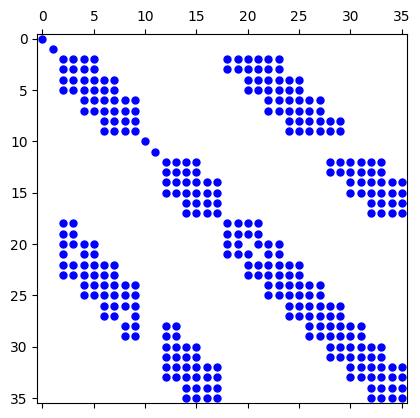

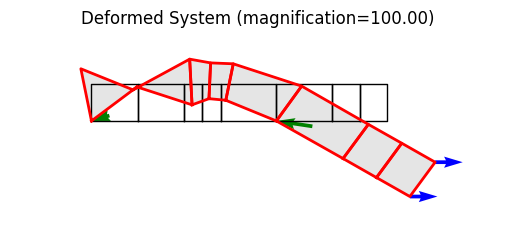

In [57]:
#IRREGULAR MESH 8 elements


import numpy as np

from femedu.examples import Example

from femedu.domain import System, Node
from femedu.solver import NewtonRaphsonSolver
from femedu.elements.linear import Quad
from femedu.materials import PlaneStress


class ExamplePlate03(Example):

    def problem(self):
        # ========== setting mesh parameters ==============

        N = 4         # number of elements in the mesh
        Lx = 800.0    # length of plate in the x-direction
        Ly =  100.0    # length of plate in the y-direction

        # ========== setting material parameters ==============

        params = dict(
            E  = 70000.,    # Young's modulus
            nu = 0.350,     # Poisson's ratio
            t  = .35       # thickness of the plate
        )

        # ========== setting load parameters ==============

        px  = .5        # uniform load normal to x=const
        py  =  .5       # uniform load normal to y=const
        pxy =  0   # uniform shear load on x=const and y=const

        # ========== setting analysis parameters ==============

        target_load_level = 1.00     # reference load
        max_steps = 2                # number of load steps: 2 -> [0.0, 1.0]

        # define a list of target load levels
        load_levels = np.linspace(0, target_load_level, max_steps)

        #
        # ==== Build the system model ====
        #

        model = System()
        model.setSolver(NewtonRaphsonSolver())

        # create nodes
        nodes = (
            Node(0.0*Lx, 0.0*Ly),       # nd 0
            Node(0.15625*Lx, 0.0*Ly),   # nd 1 (new)
            Node(0.3125*Lx, 0.0*Ly),    # nd 2
            Node(0.375*Lx, 0.0*Ly),     # nd 3 (new)
            Node(0.4375*Lx, 0.0*Ly),    # nd 4
            Node(0.625*Lx, 0.0*Ly),     # nd 5 (new)
            Node(0.8125*Lx, 0.0*Ly),    # nd 6
            Node(0.90625*Lx, 0.0*Ly),   # nd 7 (new)
            Node(1.0*Lx, 0.0*Ly),       # nd 8
            #
            Node(0.0*Lx, 1.0*Ly),       # nd 9
            Node(0.15625*Lx, 1.0*Ly),   # nd 10 (new)
            Node(0.3125*Lx, 1.0*Ly),    # nd 11
            Node(0.375*Lx, 1.0*Ly),     # nd 12 (new)
            Node(0.4375*Lx, 1.0*Ly),    # nd 13
            Node(0.625*Lx, 1.0*Ly),     # nd 14 (new)
            Node(0.8125*Lx, 1.0*Ly),    # nd 15
            Node(0.90625*Lx, 1.0*Ly),   # nd 16 (new)
            Node(1.0*Lx, 1.0*Ly),       # nd 17
)

        elements = (
            Quad(nodes[0],nodes[9],nodes[10],nodes[1],PlaneStress(params)),  # elem 0
            Quad(nodes[1],nodes[2],nodes[11],nodes[10],PlaneStress(params)),  # elem 1
            Quad(nodes[2],nodes[3],nodes[12],nodes[11],PlaneStress(params)),  # elem 2
            Quad(nodes[3],nodes[4],nodes[13],nodes[12],PlaneStress(params)),  # elem 3
            #

            Quad(nodes[4],nodes[5],nodes[14],nodes[13],PlaneStress(params)),  # elem 0
            Quad(nodes[5],nodes[6],nodes[15],nodes[14],PlaneStress(params)),  # elem 1
            Quad(nodes[6],nodes[7],nodes[16],nodes[15],PlaneStress(params)),  # elem 2
            Quad(nodes[7],nodes[8],nodes[17],nodes[16],PlaneStress(params)),  # elem 3
            #

        )




        model.addNode(*nodes)
        model.addElement(*elements)

        # define support(s)

        fix_x = (0,5)
        fix_y = (0,5)

        for idx in fix_x:
            nodes[idx].fixDOF('ux')    # horizontal support
        for idx in fix_y:
            nodes[idx].fixDOF('uy')    # vertical support

        # ==== complete the reference load ====

        # Surface loads on the right side
        elements[7].setSurfaceLoad(1, px)
        elements[7].setSurfaceLoad(1, py)


        # these are only nodal forces as part of the reference load
        # .. load only the upper node

        model.plot(factor=0., title="undeformed system", filename="plate09_undeformed.png", show_bc=1)

        model.setLoadFactor(0.0)
        model.solve()

        # for k in range(25):
        #     name = f"plate08_mode{k:2d}.png"
        #     model.plotBucklingMode(mode=k,filename=name,factor=25)

        model.setLoadFactor(100.0)
        model.solve()

        model.solver.showKt(filename="plate09_spy_Kt.png")

        model.report()

        model.plot(factor=100., filename="plate09_deformed.png")


if __name__ == "__main__":
    ex = ExamplePlate03()
    ex.run()

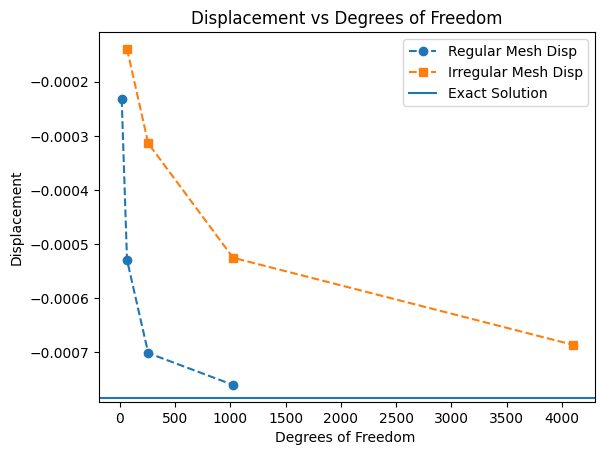

In [58]:
#convergence plots

import matplotlib.pyplot as plt

# Given data
regular_disp = [-2.32127339e-04, -5.28907219e-04, -7.01075465e-04, -7.59936402e-04]
irregular_disp= [-1.39352306e-04, -3.13663083e-04, -5.25041222e-04, -6.85680100e-04, ]
exact_sol = -0.0007836734693877551
regular_dof = [16, 64, 256, 1024]
irregular_dof = [64, 256, 1024, 4096]


# Plotting

# Plot Regular mesh
plt.plot(regular_dof, regular_disp, 'o--', label='Regular Mesh Disp')

# Plot Irregular mesh
plt.plot(irregular_dof, irregular_disp, 's--', label='Irregular Mesh Disp')

# Plot Exact Solution as a horizontal line
plt.axhline(y=exact_sol, linestyle='-', label='Exact Solution')

# Labels and title
plt.xlabel('Degrees of Freedom ')
plt.ylabel('Displacement')
plt.title('Displacement vs Degrees of Freedom')
plt.legend()

# Show the plot
plt.show()

Summary:
This assignment explored regular and irregular mesh refinements. As the refinements increased, the results got closer and closer to the exact solution.

Conclusion:

As you refine the meshes, both the regular and irregular meshes converge closer to the exact solution. Irregular meshes are more complex and likely unnecessary in a simple application as this one, so a regular mesh would be the best approach in this case.